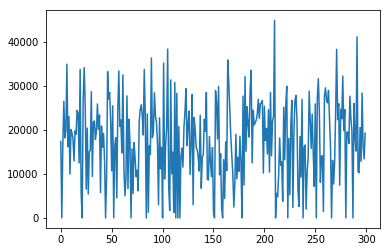

In [52]:
import numpy as Math
import pylab as Plot
import seaborn as sns


squished_embeddings = Math.load('../../../Results/Pig 2/12A/embeddings-squished.npy')
embeddings = Math.reshape(squished_embeddings, (squished_embeddings.shape[0], squished_embeddings.shape[1]))
Plot.plot(squished_embeddings[100, :])
Plot.show()

(16485, 300)


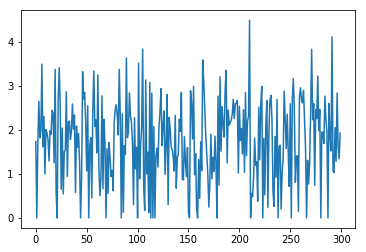

6.45541

In [53]:
print(embeddings.shape)
resized_embeddings = embeddings/10000

Plot.plot(resized_embeddings[100, :])
Plot.show()

Math.amax(resized_embeddings)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  16485 ...
Computing P-values for point  500  of  16485 ...
Computing P-values for point  1000  of  16485 ...
Computing P-values for point  1500  of  16485 ...
Computing P-values for point  2000  of  16485 ...
Computing P-values for point  2500  of  16485 ...
Computing P-values for point  3000  of  16485 ...
Computing P-values for point  3500  of  16485 ...
Computing P-values for point  4000  of  16485 ...
Computing P-values for point  4500  of  16485 ...
Computing P-values for point  5000  of  16485 ...
Computing P-values for point  5500  of  16485 ...
Computing P-values for point  6000  of  16485 ...
Computing P-values for point  6500  of  16485 ...
Computing P-values for point  7000  of  16485 ...
Computing P-values for point  7500  of  16485 ...
Computing P-values for point  8000  of  16485 ...
Computing 

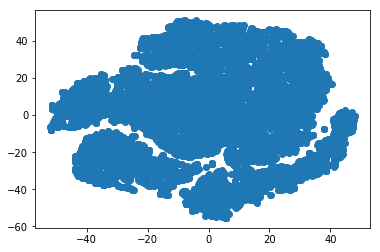

In [83]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python 2.7.10, and it requires a working
# installation of NumPy. The implementation comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.


def Hbeta(D = Math.array([]), beta = 1.0):
	"""Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

	# Compute P-row and corresponding perplexity
	P = Math.exp(-D.copy() * beta);
	sumP = sum(P);
	H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
	P = P / sumP;
	return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
	"""Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

	# Initialize some variables
	print("Computing pairwise distances...")
	(n, d) = X.shape;
	sum_X = Math.sum(Math.square(X), 1);
	D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
	P = Math.zeros((n, n));
	beta = Math.ones((n, 1));
	logU = Math.log(perplexity);

	# Loop over all datapoints
	for i in range(n):

		# Print progress
		if i % 500 == 0:
			print("Computing P-values for point ", i, " of ", n, "...")

		# Compute the Gaussian kernel and entropy for the current precision
		betamin = -Math.inf;
		betamax =  Math.inf;
		Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
		(H, thisP) = Hbeta(Di, beta[i]);

		# Evaluate whether the perplexity is within tolerance
		Hdiff = H - logU;
		tries = 0;
		while Math.abs(Hdiff) > tol and tries < 50:

			# If not, increase or decrease precision
			if Hdiff > 0:
				betamin = beta[i].copy();
				if betamax == Math.inf or betamax == -Math.inf:
					beta[i] = beta[i] * 2;
				else:
					beta[i] = (beta[i] + betamax) / 2;
			else:
				betamax = beta[i].copy();
				if betamin == Math.inf or betamin == -Math.inf:
					beta[i] = beta[i] / 2;
				else:
					beta[i] = (beta[i] + betamin) / 2;

			# Recompute the values
			(H, thisP) = Hbeta(Di, beta[i]);
			Hdiff = H - logU;
			tries = tries + 1;

		# Set the final row of P
		P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

	# Return final P-matrix
	print("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)));
	return P;


def pca(X = Math.array([]), no_dims = 50):
	"""Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

	print("Preprocessing the data using PCA...")
	(n, d) = X.shape;
	X = X - Math.tile(Math.mean(X, 0), (n, 1));
	(l, M) = Math.linalg.eig(Math.dot(X.T, X));
	Y = Math.dot(X, M[:,0:no_dims]);
	return Y;


def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
	"""Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
	The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

	# Check inputs
	if isinstance(no_dims, float):
		print("Error: array X should have type float.");
		return -1;
	if round(no_dims) != no_dims:
		print("Error: number of dimensions should be an integer.");
		return -1;

	# Initialize variables
	X = pca(X, initial_dims).real;
	(n, d) = X.shape;
	max_iter = 500;
	initial_momentum = 0.5;
	final_momentum = 0.8;
	eta = 500;
	min_gain = 0.01;
	Y = Math.random.randn(n, no_dims);
	dY = Math.zeros((n, no_dims));
	iY = Math.zeros((n, no_dims));
	gains = Math.ones((n, no_dims));

	# Compute P-values
	P = x2p(X, 1e-5, perplexity);
	P = P + Math.transpose(P);
	P = P / Math.sum(P);
	P = P * 4;									# early exaggeration
	P = Math.maximum(P, 1e-12);

	# Run iterations
	for iter in range(max_iter):

		# Compute pairwise affinities
		sum_Y = Math.sum(Math.square(Y), 1);
		num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
		num[range(n), range(n)] = 0;
		Q = num / Math.sum(num);
		Q = Math.maximum(Q, 1e-12);

		# Compute gradient
		PQ = P - Q;
		for i in range(n):
			dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);

		# Perform the update
		if iter < 20:
			momentum = initial_momentum
		else:
			momentum = final_momentum
		gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
		gains[gains < min_gain] = min_gain;
		iY = momentum * iY - eta * (gains * dY);
		Y = Y + iY;
		Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

		# Compute current value of cost function
		if (iter + 1) % 10 == 0:
			C = Math.sum(P * Math.log(P / Q));
			print("Iteration ", (iter + 1), ": error is ", C);

		# Stop lying about P-values
		if iter == 100:
			P = P / 4;

	# Return solution
	return Y;


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    #X = Math.loadtxt("mnist2500_X.txt");
    #labels = Math.loadtxt("mnist2500_labels.txt");
    Y = tsne(resized_embeddings, 2, 80);
    Plot.scatter(Y[:,0], Y[:,1]);
    Plot.show();


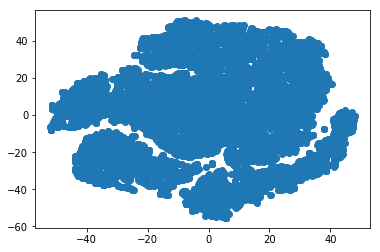

In [84]:
Math.save('../../../Results/Pig 2/12A/tsne-embeddings-perplexity-80.npy', Y)
Plot.scatter(Y[:,0], Y[:,1]);
Plot.show();

In [98]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
qualitative_clusters = 10
#my_kmeans = SpectralClustering(n_clusters=qualitative_clusters, eigen_solver='arpack',affinity="nearest_neighbors")
#my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=80)
my_kmeans = DBSCAN(eps=2.0,min_samples=10)
my_kmeans.fit_predict(Y)

rgbs = [Math.array(c) for c in sns.color_palette("husl", Math.unique(my_kmeans.labels_).shape[0])]
#my_kmeans.fit(Y)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

Plot.scatter(Y[:, 0], Y[:, 1], c=colors)
Plot.show()
#Plot.savefig('../../../Results/Pig 2/12A/DBScan_clusters-80.png')
#Math.save('../../../Results/Pig 2/12A/DBScan_labels-80.npy', labels)

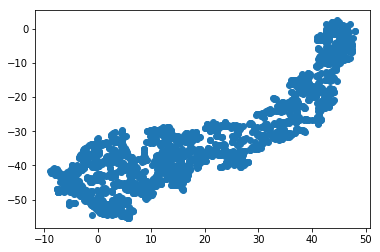

In [102]:
small_island = Y[labels == 2]
Plot.scatter(small_island[:,0], small_island[:,1])
Plot.show()